# Spaceship Titanic Competition

## Import library and datasets

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/spaceship-titanic/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sample_sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
raw_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
raw_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
def view_categoricals_feature(cat_col: str):
    d = dict()    
    total = raw_df[cat_col].value_counts()
    idx = raw_df['Transported'].value_counts().index.tolist()
    for t in idx:
        x = raw_df[raw_df['Transported']==t][cat_col].value_counts()
        d[t] = x/total*100
    
    return pd.DataFrame(data=d, columns=idx)

In [6]:
concat_df = pd.concat([raw_df, test_df]).copy()

## EDA and Feature Engineering

### Home Planet

In [7]:
concat_df['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     6865
Europa    3133
Mars      2684
NaN        288
Name: count, dtype: int64

In [8]:
concat_df.fillna({'HomePlanet': 'UNK'}, inplace=True)

### CryoSleep

In [9]:
concat_df['CryoSleep'].value_counts(dropna=False)

CryoSleep
False    8079
True     4581
NaN       310
Name: count, dtype: int64

In [10]:
concat_df.fillna({'CryoSleep': False}, inplace=True)

### Cabin

In [11]:
concat_df['Deck'] = concat_df['Cabin'].apply(lambda x: x.split('/')[0] if str(x).count('/') > 0 else 'UNK')
concat_df['Side'] = concat_df['Cabin'].apply(lambda x: x.split('/')[2] if str(x).count('/') > 1 else 'UNK')

In [12]:
concat_df['Deck'].value_counts(dropna=False)

Deck
F      4239
G      3781
E      1323
B      1141
C      1102
D       720
A       354
UNK     299
T        11
Name: count, dtype: int64

In [13]:
concat_df['Side'].value_counts(dropna=False)

Side
S      6381
P      6290
UNK     299
Name: count, dtype: int64

### Destination

In [14]:
concat_df['Destination'].value_counts(dropna=False)

Destination
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
NaN               274
Name: count, dtype: int64

In [15]:
concat_df.fillna({'Destination': 'UNK'}, inplace=True)

### Vip

In [16]:
concat_df['VIP'].value_counts(dropna=False)

VIP
False    12401
NaN        296
True       273
Name: count, dtype: int64

In [17]:
concat_df.fillna({'VIP': False}, inplace=True)

### Name

In [18]:
concat_df['FirstName'] = concat_df['Name'].apply(lambda x: x.split(' ')[0] if str(x).find(' ')!=-1 else 'unk')
concat_df['LastName'] = concat_df['Name'].apply(lambda x: x.split(' ')[1] if str(x).find(' ')!=-1 else 'unk')

In [19]:
first_name = concat_df['FirstName'].value_counts()
last_name = concat_df['LastName'].value_counts()

In [20]:
concat_df['FirstName'] = concat_df['FirstName'].apply(lambda x: x if first_name.get(x)>4 else 'rem')
concat_df['LastName'] = concat_df['LastName'].apply(lambda x: x if last_name.get(x)>4 else 'rem')

### Passenger Id

In [21]:
concat_df['GroupId'] = concat_df['PassengerId'].map(lambda x: x[0:4])

In [22]:
group_count = concat_df['GroupId'].value_counts()
concat_df['NumInGroup'] = concat_df['GroupId'].apply(lambda x: group_count.get(x))

### Age

In [23]:
concat_df['Age'].describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [24]:
avg_age = concat_df['Age'].mean()
concat_df.fillna({'Age': avg_age}, inplace=True)

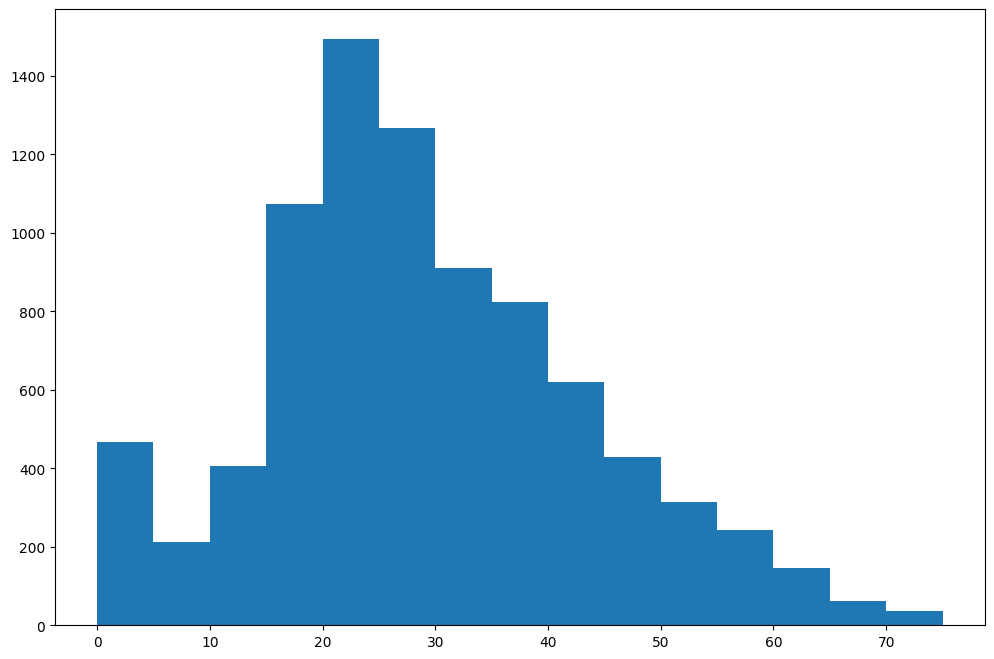

In [25]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['Age'], bins=np.arange(0,80,5));

In [26]:
concat_df['AgeGroup'] = pd.cut(concat_df['Age'],
                               bins=[-1,5,14,18,30,52,100],
                               labels=['Baby','Child','Teenager','Adult','OldAdult','Old'])

In [27]:
concat_df['CanHandle'] = concat_df['AgeGroup'].apply(lambda x: 1 if x in ['Baby', 'Child'] else 0)

### Costs

In [28]:
imputer = SimpleImputer()
imputer.fit(concat_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])

SimpleImputer()

In [29]:
concat_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = imputer.transform(concat_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])

In [30]:
concat_df['TotalPrice'] = concat_df['RoomService'] + concat_df['FoodCourt'] + concat_df['ShoppingMall'] + concat_df['Spa'] + concat_df['VRDeck']

In [31]:
def count_amenity(x):
    total = 0
    for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
        if x[col] > 0:
            total += 1
    return total

In [32]:
concat_df['TotalAmenity'] = raw_df.apply(count_amenity, axis=1)

In [33]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalPrice']:
    concat_df[f'log_{col}'] = np.log(concat_df[col] + 1.5)

In [34]:
concat_df['avg_log_TotalPrice_GroupId'] = concat_df.groupby('GroupId')['log_TotalPrice'].transform('mean')
concat_df['avg_log_TotalPrice_AgeGroup'] = concat_df.groupby('AgeGroup')['log_TotalPrice'].transform('mean')

### Preprocessing

In [35]:
concat_df.dtypes

PassengerId                      object
HomePlanet                       object
CryoSleep                          bool
Cabin                            object
Destination                      object
Age                             float64
VIP                                bool
RoomService                     float64
FoodCourt                       float64
ShoppingMall                    float64
Spa                             float64
VRDeck                          float64
Name                             object
Transported                      object
Deck                             object
Side                             object
FirstName                        object
LastName                         object
GroupId                          object
NumInGroup                        int64
AgeGroup                       category
CanHandle                         int64
TotalPrice                      float64
TotalAmenity                      int64
log_RoomService                 float64


In [36]:
categorical_cols = ['HomePlanet','CryoSleep','Destination','VIP',
                    'Deck','Side','FirstName','LastName','GroupId',
                    'AgeGroup']
numeric_cols = concat_df.select_dtypes(include=[np.float64,np.int64]).columns.tolist()

In [37]:
encoder = OrdinalEncoder()
concat_df[categorical_cols] = encoder.fit_transform(concat_df[categorical_cols])

In [38]:
concat_df[categorical_cols] = concat_df[categorical_cols].astype('int32')

In [39]:
raw_df = concat_df[concat_df['Transported'].isna()==False] 
test_df = concat_df[concat_df['Transported'].isna()]

In [40]:
input_cols = numeric_cols+categorical_cols

In [41]:
inputs = raw_df[input_cols]
test_inputs = test_df[input_cols]

In [42]:
raw_df['Transported'] = raw_df['Transported'].apply(lambda x: 1 if x==True else 0)

/tmp/ipykernel_17/672608153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['Transported'] = raw_df['Transported'].apply(lambda x: 1 if x==True else 0)


In [43]:
targets = raw_df['Transported']

## Mutual info

In [44]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

CPU times: user 1.09 s, sys: 6.38 ms, total: 1.1 s
Wall time: 1.11 s


,Numerical_Feature_MI
TotalPrice,0.133410
log_TotalPrice,0.129225
TotalAmenity,0.126676
CryoSleep,0.113691
avg_log_TotalPrice_GroupId,0.096861
log_Spa,0.081416
RoomService,0.073670
Spa,0.072794
log_RoomService,0.067238
VRDeck,0.063512


In [45]:
importance_cols = ['log_TotalPrice','TotalAmenity','CryoSleep',
                  'avg_log_TotalPrice_GroupId','log_Spa',
                  'log_RoomService','log_VRDeck','log_ShoppingMall',
                  'log_FoodCourt','HomePlanet','GroupId','LastName',
                  'avg_log_TotalPrice_AgeGroup','AgeGroup',
                  'Deck','FirstName','CanHandle','NumInGroup',
                  'Age','VIP','Destination']

In [46]:
len(input_cols), len(importance_cols)

(28, 21)

## Model and training model

In [47]:
def cross_validation(clf, cv, inputs, targets, test_inputs=None, need_print=False):
    train_accs = []
    val_accs = []
    test_pred_memo = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        clf.fit(X_train, y_train)

        train_pred = clf.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        val_pred = clf.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        val_accs.append(val_acc)

        if need_print:
            print(f'Fold {fold}: train_acc = {train_acc:.5f}, val_acc = {val_acc:.5f}')

        if test_inputs is not None:
            test_pred = clf.predict_proba(test_inputs)[:,1]
            test_preds += test_pred/cv.get_n_splits()
            
            test_pred = clf.predict(test_inputs)
            test_pred_memo.append(test_pred)

    m_train_acc = np.mean(train_accs)
    s_train_acc = np.std(train_accs)
    m_val_acc = np.mean(val_accs)
    s_val_acc = np.std(val_accs)
    
    msg = f'{m_val_acc:.7f} ± {s_val_acc:.7f}'
    
    if need_print:
        print(f'Train acc: {m_train_acc:.7f} ± {s_train_acc:.7f} | Val acc: {m_val_acc:.7f} ± {s_val_acc:.7f}')
    return test_preds, test_pred_memo, msg

In [48]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Classifier'] = []
    for feature, _ in features.items():
        result[f'Acc with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Classifier'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, _, msg = cross_validation(model, cv, 
                                         inputs, targets, 
                                         test_inputs=None, 
                                         need_print=False)
            result[f'Acc with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [49]:
classifiers = {
    'RandomForest': RandomForestClassifier(n_jobs=-1),
    'XGB': XGBClassifier(n_jobs=-1),
    'LGBM' : LGBMClassifier(n_jobs=-1,verbose=0),
    'CAT': CatBoostClassifier(logging_level='Silent')
}
features = {
    'all': input_cols,
    'importance': importance_cols
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
%%time
test_with_models(classifiers, features, raw_df, 'Transported', cv)

CPU times: user 3min 13s, sys: 26.8 s, total: 3min 40s
Wall time: 1min 6s


,Classifier,Acc with all features,Acc with importance features
0,RandomForest,0.7961567 ± 0.0075186,0.7910949 ± 0.0115531
1,XGB,0.8002986 ± 0.0065458,0.7898311 ± 0.0074824
2,LGBM,0.8020242 ± 0.0065750,0.7966174 ± 0.0071414
3,CAT,0.8093877 ± 0.0089147,0.8051301 ± 0.0082301


So we choose all features

In [51]:
scores = {
    'Classifier': [],
    'Train Acc': [],
    'Val Acc': [],
    'Test Acc': []
}

### RF

In [52]:
%%time
rf = RandomForestClassifier(n_jobs=-1)
test_preds, test_pred_memo, _ = cross_validation(rf, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 1.00000, val_acc = 0.79931
Fold 1: train_acc = 1.00000, val_acc = 0.78896
Fold 2: train_acc = 1.00000, val_acc = 0.80851
Fold 3: train_acc = 1.00000, val_acc = 0.80092
Fold 4: train_acc = 1.00000, val_acc = 0.78366
Train acc: 1.0000000 ± 0.0000000 | Val acc: 0.7962719 ± 0.0088677
CPU times: user 9.92 s, sys: 25.3 ms, total: 9.95 s
Wall time: 9.95 s


In [53]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_rf.csv', index=None)

In [54]:
scores['Classifier'].append('RF without tuning')
scores['Train Acc'].append(1.00000)
scores['Val Acc'].append(0.79915)
scores['Test Acc'].append(0.79074)

In [55]:
param_dis = {
    'n_estimators': np.arange(50,500,50),
    'max_depth': np.arange(10,70,6),
    'min_samples_split': np.arange(2,6),
    'min_samples_leaf': np.arange(1,5),
    'max_features': ['sqrt','log2',None],
    'min_weight_fraction_leaf': loguniform(1e-6,0.4),
    'max_leaf_nodes': np.arange(20,600,45),
    'n_jobs': [-1],
    'random_state': [0,17,42,123,1212],
    'max_samples': loguniform(0.2,1)
}

In [56]:
'''%%time
search = RandomizedSearchCV(RandomForestClassifier(),
                            param_dis,
                            n_iter=80,
                            scoring='accuracy', cv=cv,
                            refit=True, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(RandomForestClassifier(),\n                            param_dis,\n                            n_iter=80,\n                            scoring='accuracy', cv=cv,\n                            refit=True, verbose=3)\nsearch.fit(inputs, targets)"

In [57]:
best_params = {
 'max_depth': 28,
 'max_features': None,
 'max_leaf_nodes': 335,
 'max_samples': 0.24520523651775328,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 8.713898917237253e-05,
 'n_estimators': 400,
 'n_jobs': -1,
 'random_state': 0
}

In [58]:
%%time
rf = RandomForestClassifier(**best_params)
test_preds, test_pred_memo, _ = cross_validation(rf, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.88812, val_acc = 0.79873
Fold 1: train_acc = 0.89114, val_acc = 0.78838
Fold 2: train_acc = 0.89172, val_acc = 0.80909
Fold 3: train_acc = 0.88886, val_acc = 0.79862
Fold 4: train_acc = 0.89547, val_acc = 0.79632
Train acc: 0.8910617 ± 0.0025838 | Val acc: 0.7982283 ± 0.0066159
CPU times: user 46.6 s, sys: 50.5 ms, total: 46.6 s
Wall time: 46.6 s


In [59]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_rf_tuning.csv', index=None)

In [60]:
scores['Classifier'].append('RF with tuning')
scores['Train Acc'].append(0.89106)
scores['Val Acc'].append(0.79822)
scores['Test Acc'].append(0.57446)

### XGB

In [61]:
%%time
xgb = XGBClassifier(n_jobs=-1)
test_preds, test_pred_memo, _ = cross_validation(xgb, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.96391, val_acc = 0.80621
Fold 1: train_acc = 0.96808, val_acc = 0.79356
Fold 2: train_acc = 0.97239, val_acc = 0.80506
Fold 3: train_acc = 0.97009, val_acc = 0.80552
Fold 4: train_acc = 0.96808, val_acc = 0.79114
Train acc: 0.9685091 ± 0.0027977 | Val acc: 0.8002986 ± 0.0065458
CPU times: user 2.85 s, sys: 17.7 ms, total: 2.87 s
Wall time: 2.86 s


In [62]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_xgb.csv', index=None)

In [63]:
scores['Classifier'].append('XGB without tuning')
scores['Train Acc'].append(0.96851)
scores['Val Acc'].append(0.80030)
scores['Test Acc'].append(0.75964)

In [64]:
param_dis = {
    'n_estimators': np.arange(100,600,150),
    'max_depth': np.arange(8,17,2),
    'learning_rate': loguniform(0.009,0.25),
    'reg_lambda': loguniform(1e-5,5),
    'subsample': loguniform(0.5,1),
    'min_child_weight': loguniform(0.4,5),
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'colsample_bytree': loguniform(0.25,1),
    'n_jobs': [-1],
    'max_bin': [256,1024]
}

In [65]:
'''%%time
search = RandomizedSearchCV(XGBClassifier(), param_dis, 
                            n_iter=150, refit=True,
                            scoring = 'accuracy',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(XGBClassifier(), param_dis, \n                            n_iter=150, refit=True,\n                            scoring = 'accuracy',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [66]:
best_params = {
 'colsample_bytree': 0.5704035544959706,
 'learning_rate': 0.01057734726899081,
 'max_bin': 256,
 'max_depth': 12,
 'min_child_weight': 2.577854328449342,
 'n_estimators': 550,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'reg_lambda': 2.3051847677178476,
 'subsample': 0.6043893970395925,
 'tree_method': 'hist'
}

In [67]:
%%time
xgb = XGBClassifier(**best_params)
test_preds, test_pred_memo, _ = cross_validation(xgb, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.92235, val_acc = 0.80621
Fold 1: train_acc = 0.92479, val_acc = 0.80334
Fold 2: train_acc = 0.92637, val_acc = 0.81484
Fold 3: train_acc = 0.92509, val_acc = 0.80783
Fold 4: train_acc = 0.92653, val_acc = 0.79747
Train acc: 0.9250258 ± 0.0015038 | Val acc: 0.8059351 ± 0.0056802
CPU times: user 29 s, sys: 335 ms, total: 29.3 s
Wall time: 29.3 s


In [68]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_xgb_tuning.csv', index=None)

In [69]:
scores['Classifier'].append('XGB with tuning')
scores['Train Acc'].append(0.92503)
scores['Val Acc'].append(0.80594)
scores['Test Acc'].append(0.78629)

### LGBM

In [70]:
%%time
lgbm = LGBMClassifier(n_jobs=-1, verbose=-1)
test_preds, test_pred_memo, _ = cross_validation(lgbm, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.90883, val_acc = 0.80334
Fold 1: train_acc = 0.90955, val_acc = 0.79873
Fold 2: train_acc = 0.90811, val_acc = 0.80736
Fold 3: train_acc = 0.90726, val_acc = 0.80955
Fold 4: train_acc = 0.90971, val_acc = 0.79114
Train acc: 0.9086909 ± 0.0009127 | Val acc: 0.8020242 ± 0.0065750
CPU times: user 2.52 s, sys: 1.8 ms, total: 2.52 s
Wall time: 2.52 s


In [71]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_lgbm.csv', index=None)

In [72]:
scores['Classifier'].append('LGBM without tuning')
scores['Train Acc'].append(0.90869)
scores['Val Acc'].append(0.80202)
scores['Test Acc'].append(0.77414)

In [73]:
param_dis = {
    'num_leaves': np.arange(32,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(50,341,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(15,55,4),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(8,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [-1]
}

In [74]:
'''%%time
search = RandomizedSearchCV(LGBMClassifier(), param_dis, 
                            n_iter=150, refit=True,
                            scoring = 'accuracy',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(LGBMClassifier(), param_dis, \n                            n_iter=150, refit=True,\n                            scoring = 'accuracy',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [75]:
best_params = {
 'colsample_bytree': 0.4061085734468846,
 'learning_rate': 0.05034075959033461,
 'max_depth': 39,
 'min_child_samples': 24,
 'min_child_weight': 0.007321631014810341,
 'min_split_gain': 0.01755821643745654,
 'n_estimators': 210,
 'n_jobs': -1,
 'num_leaves': 81,
 'random_state': 42,
 'reg_alpha': 0.6912607880108492,
 'reg_lambda': 8.033509871111954e-05,
 'subsample': 0.3938468258049639,
 'verbose': -1
}

In [76]:
%%time
lgbm = LGBMClassifier(**best_params)
test_preds, test_pred_memo, _ = cross_validation(lgbm, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.97282, val_acc = 0.80909
Fold 1: train_acc = 0.97527, val_acc = 0.79873
Fold 2: train_acc = 0.97340, val_acc = 0.80794
Fold 3: train_acc = 0.97168, val_acc = 0.81646
Fold 4: train_acc = 0.97426, val_acc = 0.79689
Train acc: 0.9734844 ± 0.0012249 | Val acc: 0.8058210 ± 0.0071854
CPU times: user 6.9 s, sys: 4.53 ms, total: 6.91 s
Wall time: 6.91 s


In [77]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_lgbm_tuning.csv', index=None)

In [78]:
scores['Classifier'].append('LGBM with tuning')
scores['Train Acc'].append(0.97348)
scores['Val Acc'].append(0.80582)
scores['Test Acc'].append(0.79003)

### CatBoost

In [79]:
%%time
cat = CatBoostClassifier(logging_level='Silent')
test_preds, test_pred_memo, _ = cross_validation(cat, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.89747, val_acc = 0.80621
Fold 1: train_acc = 0.89790, val_acc = 0.80621
Fold 2: train_acc = 0.90078, val_acc = 0.80851
Fold 3: train_acc = 0.89619, val_acc = 0.82624
Fold 4: train_acc = 0.89576, val_acc = 0.79977
Train acc: 0.8976189 ± 0.0017650 | Val acc: 0.8093877 ± 0.0089147
CPU times: user 1min 23s, sys: 12.8 s, total: 1min 36s
Wall time: 27 s


In [80]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_cat.csv', index=None)

In [81]:
scores['Classifier'].append('CAT without tuning')
scores['Train Acc'].append(0.89762)
scores['Val Acc'].append(0.80939)
scores['Test Acc'].append(0.80009)

In [82]:
param_dis = {
    'eval_metric': ['Accuracy'],
    'iterations': np.arange(750,2500,250),
    'learning_rate': loguniform(0.005,0.15),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,4),
    'border_count': np.arange(24,296,50),
    'logging_level': ['Silent']
}

In [83]:
'''%%time
search = RandomizedSearchCV(CatBoostClassifier(), param_dis, 
                            n_iter=100, refit=True,
                            scoring = 'accuracy',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(CatBoostClassifier(), param_dis, \n                            n_iter=100, refit=True,\n                            scoring = 'accuracy',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [84]:
best_params = {
 'bagging_temperature': 0.7070111158416169,
 'border_count': 174,
 'depth': 9,
 'eval_metric': 'Accuracy',
 'iterations': 2000,
 'l2_leaf_reg': 0.8238074734091383,
 'learning_rate': 0.007059702818146471,
 'logging_level': 'Silent',
 'min_data_in_leaf': 1,
 'random_seed': 42,
 'random_strength': 9
}

In [85]:
%%time
cat = CatBoostClassifier(**best_params)
test_preds, test_pred_memo, _ = cross_validation(cat, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.93097, val_acc = 0.81024
Fold 1: train_acc = 0.92997, val_acc = 0.80736
Fold 2: train_acc = 0.93256, val_acc = 0.81944
Fold 3: train_acc = 0.92725, val_acc = 0.81876
Fold 4: train_acc = 0.92825, val_acc = 0.80380
Train acc: 0.9298000 ± 0.0018932 | Val acc: 0.8119175 ± 0.0062104
CPU times: user 7min 11s, sys: 32.9 s, total: 7min 44s
Wall time: 2min 8s


In [86]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_cat_tuning.csv', index=None)

In [87]:
scores['Classifier'].append('LGBM with tuning')
scores['Train Acc'].append(0.92980)
scores['Val Acc'].append(0.81192)
scores['Test Acc'].append(0.79845)

### Stacking

In [88]:
level0 = list()
level0.append(('rf', RandomForestClassifier(n_jobs=-1)))
level0.append(('cat', CatBoostClassifier(logging_level='Silent')))

stack = StackingClassifier(estimators=level0, cv=cv)

In [89]:
%%time
test_preds, test_pred_memo, _ = cross_validation(stack, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.90610, val_acc = 0.80794
Fold 1: train_acc = 0.91458, val_acc = 0.80391
Fold 2: train_acc = 0.91027, val_acc = 0.81081
Fold 3: train_acc = 0.91733, val_acc = 0.82163
Fold 4: train_acc = 0.91531, val_acc = 0.80092
Train acc: 0.9127169 ± 0.0040318 | Val acc: 0.8090423 ± 0.0071443
CPU times: user 8min 33s, sys: 1min 11s, total: 9min 44s
Wall time: 3min 14s


In [90]:
sample_sub_df['Transported'] = test_preds
sample_sub_df['Transported'] = sample_sub_df['Transported'].apply(lambda x: True if x>=0.5 else False)
sample_sub_df.to_csv('/kaggle/working/sub_stack_rf_cat.csv', index=None)

In [91]:
scores['Classifier'].append('Stacking RF, CAT')
scores['Train Acc'].append(0.91735)
scores['Val Acc'].append(0.80950)
scores['Test Acc'].append(0.79962)

### View LB Score

In [92]:
scores_df = pd.DataFrame(scores)
scores_df.style.background_gradient("cool")

,Classifier,Train Acc,Val Acc,Test Acc
0,RF without tuning,1.000000,0.799150,0.790740
1,RF with tuning,0.891060,0.798220,0.574460
2,XGB without tuning,0.968510,0.800300,0.759640
3,XGB with tuning,0.925030,0.805940,0.786290
4,LGBM without tuning,0.908690,0.802020,0.774140
5,LGBM with tuning,0.973480,0.805820,0.790030
6,CAT without tuning,0.897620,0.809390,0.800090
7,LGBM with tuning,0.929800,0.811920,0.798450
8,"Stacking RF, CAT",0.917350,0.809500,0.799620


So CAT without tuning have the best performance in test datas.

In [93]:
sample_sub_df = pd.read_csv('/kaggle/working/sub_cat.csv')
sample_sub_df.to_csv('/kaggle/working/submission.csv', index=None)